In [1]:
import numpy as np
import sklearn as skl
import matplotlib.pylab as plt
import pylab
from mpl_toolkits.mplot3d import Axes3D

from sklearn.cluster import KMeans

import scipy.linalg as la
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

import warnings

# Fix randoom seed for reproducibility
np.random.seed(42)

In [2]:
NUM_NODES = 1005

In [3]:
# initialize data matrix which will be an adjacency matrix
DATA = np.zeros((NUM_NODES, NUM_NODES))

# fill out the symmetric adjacency matrix
with open("email-Eu-core.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        DATA[pair[0], pair[1]] = 1
        DATA[pair[1], pair[0]] = 1

In [4]:
from sklearn.metrics.pairwise import cosine_similarity

class ConstantShiftEmbedding(skl.base.BaseEstimator, skl.base.TransformerMixin):
    """Template class for Constant Shift Embedding (CSE)
    
    Attributes:
        PMAT (np.ndarray): Proximity matrix used for calculating the embeddings.
        S (np.ndarray): Similarity matrix.
        D (np.ndarray): Dissimilarity matrix.
        
    """
    
    def __init__(self):
        #TODO: remove params not used outside of this function
        self.PMAT = None
        self.S_c = None # centered Similarity matrix
        self.S_shifted = None # shifted Similarity matrix
        self.D_shifted = None # shifted Dissimilarity matrix
        # Add/change parameters, if necessary.
    
    def fit(self, PMAT):
        """ Calculate similarity/dissimiliarity matrix and all
        the necessary variables for calculating the embeddings.
        
        Args:
            PMAT (np.ndarray): proximity matrix
        """
        # Save data
        self.PMAT = PMAT
        n = PMAT.shape[0] 
        
        # computes symmetrized D
        D = 1-cosine_similarity(PMAT.copy())
        D[D == np.inf] = 12
        
        sym_D=0.5*(D.T+D) #we calculate the symmetrized Dissimilarity matrix
        centr_matrix=np.eye(n)-1/n*np.ones((n,n))
        
        D_centr=np.matmul(centr_matrix, sym_D.dot(centr_matrix)) #calculates centred Dissimilarity
        self.S_c=-0.5*D_centr #calculates centred Similarity
        
        eig=np.linalg.eigvalsh(self.S_c) #computes eigenvalues of S_c
        lambda_min=eig[0] #eigvalsh returns eigenvalues in ascending order, hence this line takes minimum eigenvalue of S_c
        
        self.D_shifted=sym_D-2*lambda_min*(np.ones((n,n))-np.eye(n))
        
        self.S_shifted=-0.5*np.matmul(centr_matrix, self.D_shifted.dot(centr_matrix))
    
    
        
    def get_embedded_vectors(self, p=None):
        """Return embeddings
        
        Args:
            p (np.ndarray): cut-off value in eigenspectrum
        
        Returns:
            Xp (np.ndarray): embedded vectors
        
        """
        n = self.PMAT.shape[0]
        
        eigenvalues, eigenvectors=np.linalg.eigh(self.S_shifted)
        
        sorted_eigenvalues=eigenvalues[::-1] #sort eigenvalues in descending order
        sorted_eigenvectors=eigenvectors[:, ::-1]
        
        #it may happen for numerical approximations that the last eigenvalue
        #which is supposed to be 0 is actually negative. We then set it to 0 by hand
        #as otherwise it may return a Nan value when we calculate the square root for the embedding
        
        for i in range(len(sorted_eigenvalues)):
            if sorted_eigenvalues[i]<0:
                sorted_eigenvalues[i]=0 
        
        if p is not None:
            lambda_p=np.diag(sorted_eigenvalues[0:p]) #construct diagonal matrices of p biggest eigenvalues
            eigenvectors_p=sorted_eigenvectors[:, 0:p] #takes the eigenvectors corresponding to p biggest eigenvalues
        
        else:
            lambda_p=np.diag(sorted_eigenvalues)
            eigenvectors_p=sorted_eigenvectors.copy()

        X_p=eigenvectors_p.dot(np.sqrt(lambda_p))
        return X_p

In [5]:
CSE = ConstantShiftEmbedding()

In [6]:
CSE.fit(DATA)

In [7]:
#section 4.5

In [8]:
S_c_eigenvalues=np.linalg.eigvalsh(CSE.S_c) #we calculate the eigenvalues of the centred similarity matrix

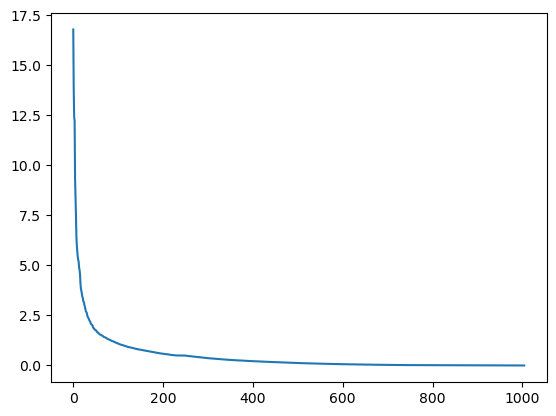

In [9]:
#we first plot the eigenvalues to decide which cut-off to take 

plt.plot(S_c_eigenvalues[::-1]) 

In [10]:
p_opt=40 

print("We have estimated an optimal cutoff of " + str(p_opt))

#To estimate the optimal cutoff, we simply looked at the plot above and took the value where
#the eigenvalue curve had an "elbow", i.e. eigenvalues start to decrease slower after this point 
#(this method is indeed often called "elbow" in PCA).The rationale behind this is saying that
#since the eigenvalues start to decrease much slower, they don't have as much contribution in the corresponding
#eigendirections as the bigger ones have in their respective. Hence, we are "allowed" to discard them since
#we can assume that they essentially do not contribute in shaping the manifold the data lives in

We have estimated an optimal cutoff of 40


C:\Users\faran\AppData\Local\Temp\ipykernel_23500\2032406359.py:7: UserWarning: The label '_' of <matplotlib.lines.Line2D object at 0x000001FB8027B940> starts with '_'. It is thus excluded from the legend.
  plt.legend('p_opt', ) #choose which line


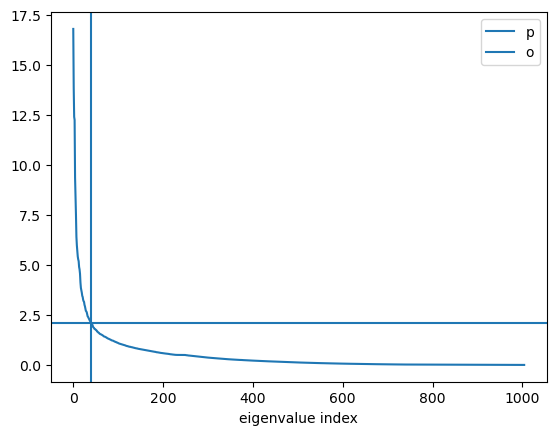

In [11]:
#no we plot the eigenvalues again with the p_opt threshold, as in figure 4a) of reference 1)

warnings.filterwarnings("ignore")

plt.plot(S_c_eigenvalues[::-1])
plt.axhline(y=S_c_eigenvalues[-p_opt], linestyle='-')
plt.axvline(x=p_opt, linestyle='-')
plt.xlabel('eigenvalue index')
plt.legend('p_opt', ) #choose which line
plt.show()

In [12]:
#section 5

In [29]:
#aligning clustering labels with ground truth labels (taken from previous assignment)

def match(y_pred, y_truth):
    
    labels_map = np.argmax(skl.metrics.cluster.contingency_matrix(y_pred, y_truth), axis=1)
    y_new = []
    for y in y_pred:
        y_new.append(labels_map[y])
        
    return np.array(y_new)


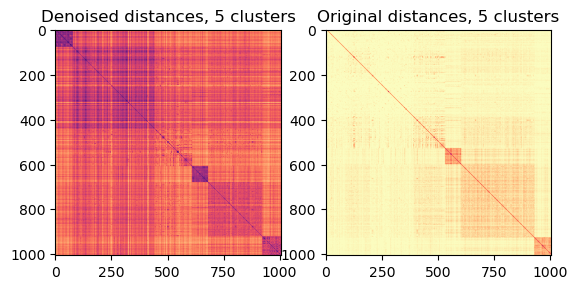

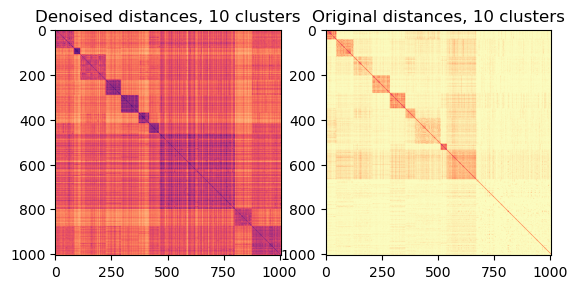

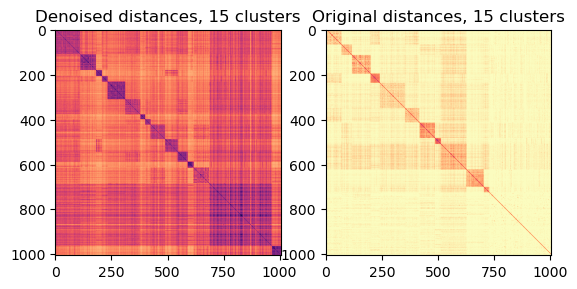

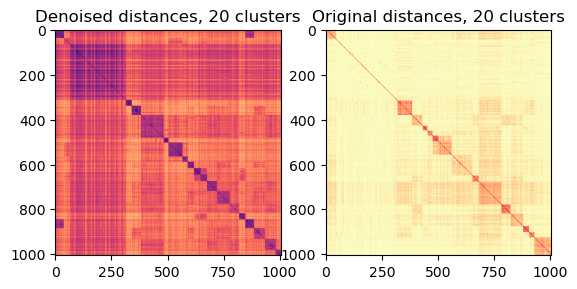

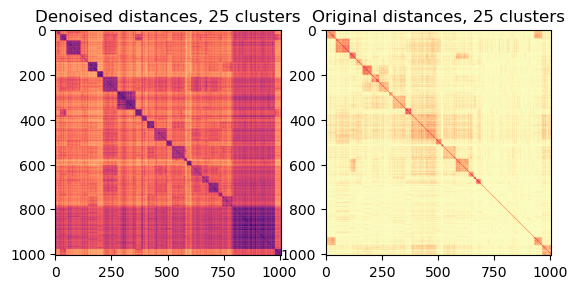

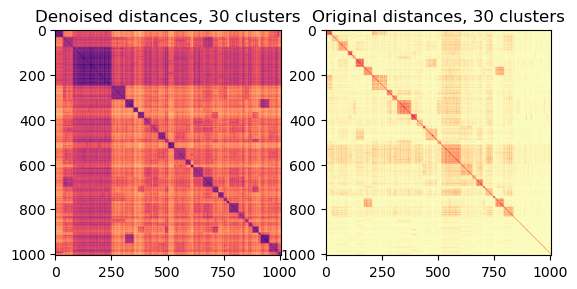

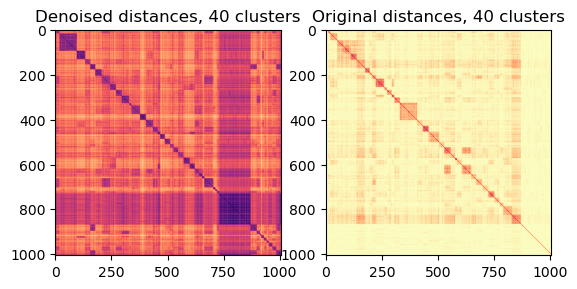

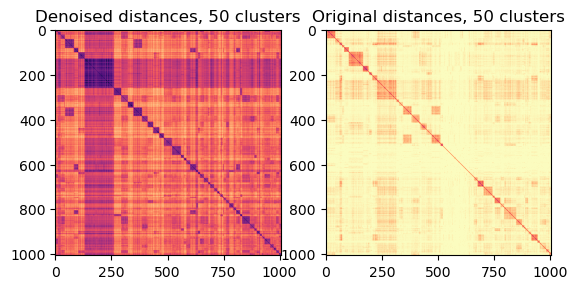

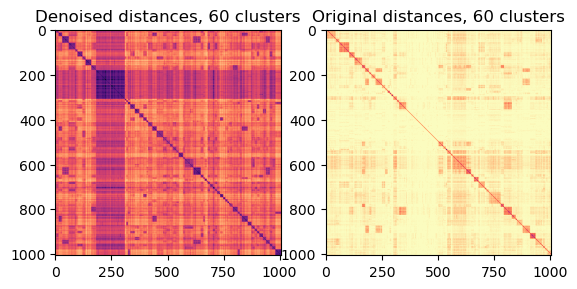

In [30]:
import scipy.spatial as spt 

denoised_embedded_points=CSE.get_embedded_vectors(p=p_opt)
original_embedded_points=CSE.get_embedded_vectors()

for k in [5,10,15,20,25,30, 40, 50, 60]:
    
    fix, axs= plt.subplots(1,2)
    denoised_distance = spt.distance.squareform(spt.distance.pdist(denoised_embedded_points)) #calculates the distance matrix
    cluster_predictions = skl.cluster.KMeans(k).fit_predict(denoised_embedded_points) #calculates cluster predictions
    idx = np.argsort(cluster_predictions) #sorts the points with respect to cluster assignment
    axs[0].imshow(denoised_distance[idx][:,idx], cmap='magma')
    axs[0].set_title('Denoised distances, '+str(k) +' clusters')
    
    original_distance = spt.distance.squareform(spt.distance.pdist(original_embedded_points))
    original_cluster_predictions= skl.cluster.KMeans(k).fit_predict(original_embedded_points)
    
    #we need to match original cluster predictions labels with the denoised cluster predictions labels

    matched_original_cluster_predictions=match(cluster_predictions, original_cluster_predictions)
    matched_idx = np.argsort(matched_original_cluster_predictions)
    axs[1].imshow(original_distance[matched_idx][:,matched_idx], cmap='magma')
    axs[1].set_title('Original distances, '+str(k) +' clusters')
    
    

In [15]:
#section 5.5

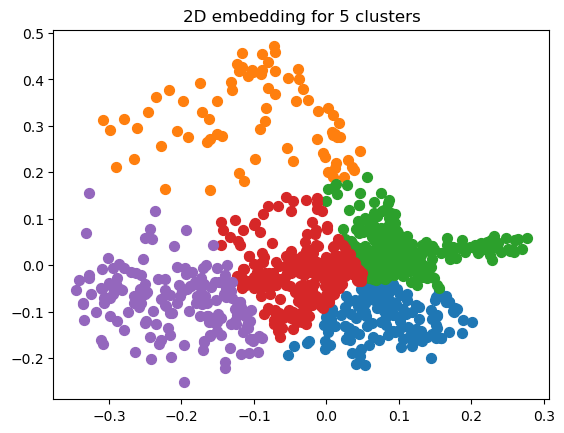

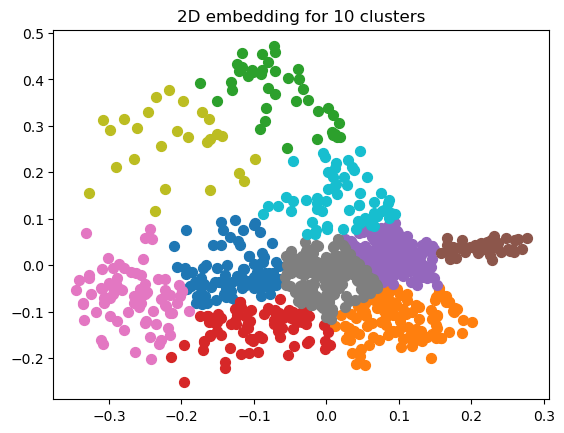

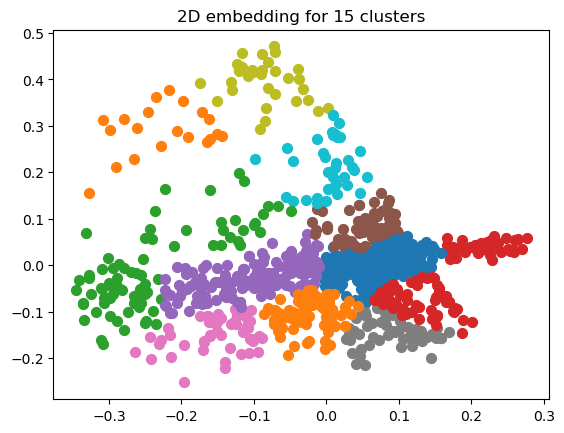

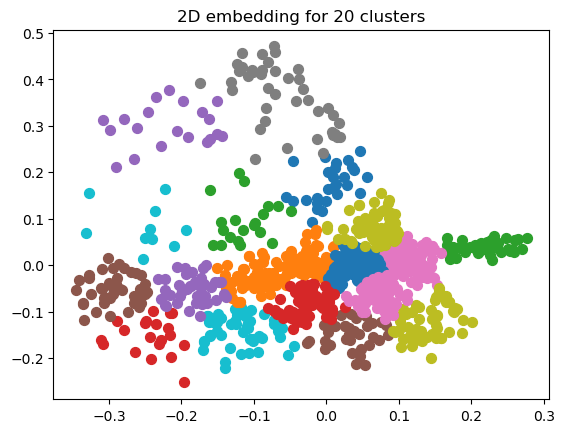

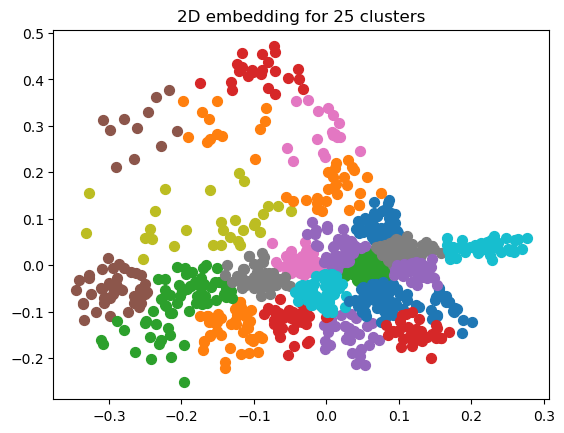

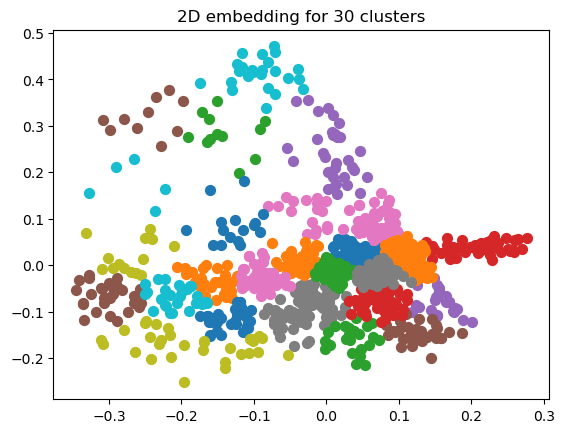

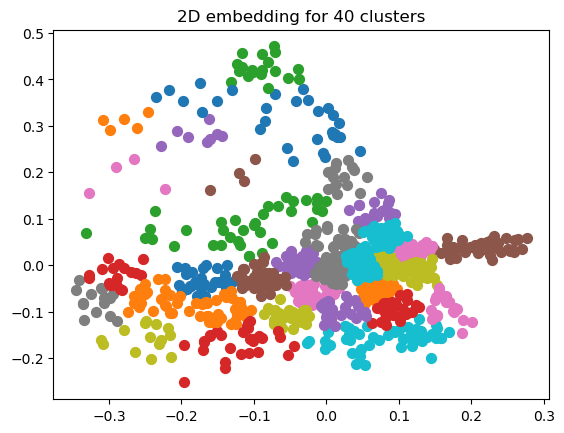

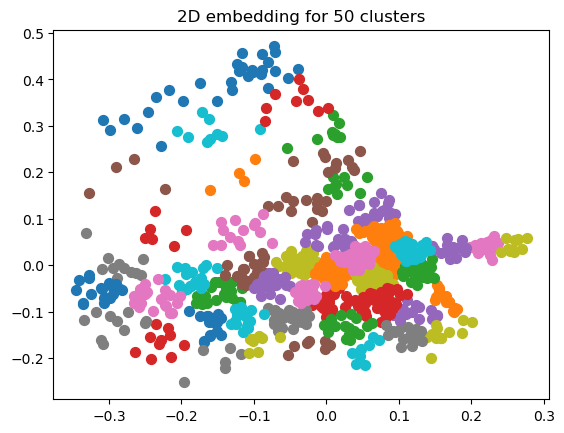

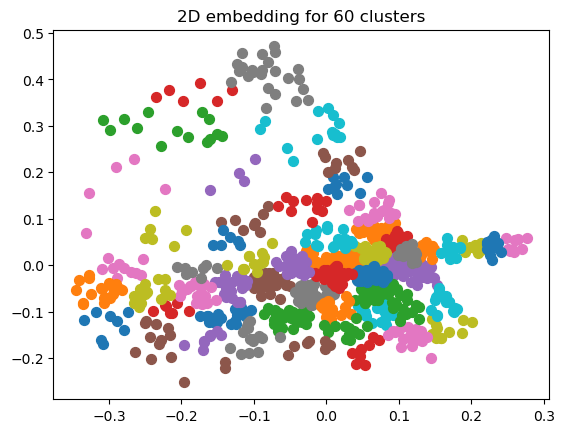

In [31]:
#2d embedding (p=2)

warnings.filterwarnings("ignore")

embedded_points_2d=CSE.get_embedded_vectors(p=2)

for k in [5,10,15,20,25,30, 40, 50, 60]:
    
    cluster_predictions=skl.cluster.KMeans(k).fit_predict(embedded_points_2d)
    
    plt.figure()
    
    for i in range(k):
        indices=np.where(cluster_predictions==i)
        plt.scatter(embedded_points_2d[indices, 0], embedded_points_2d[indices, 1], s=50)
    
    plt.title("2D embedding for " + str(k) + " clusters")

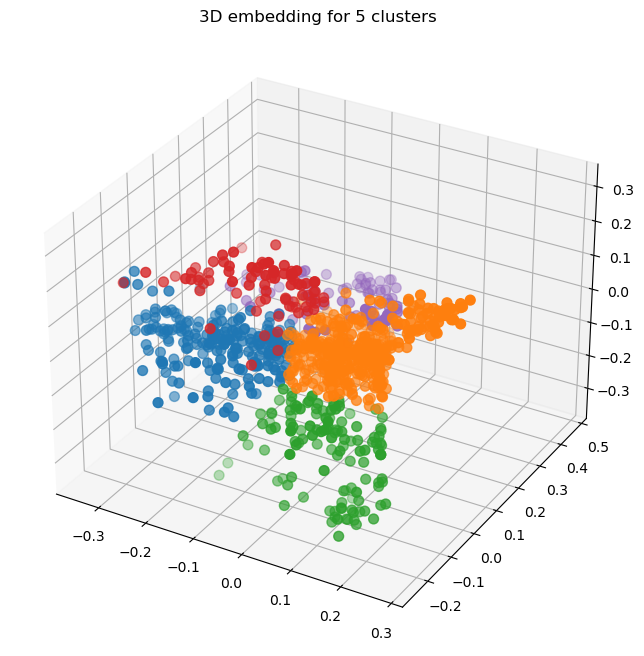

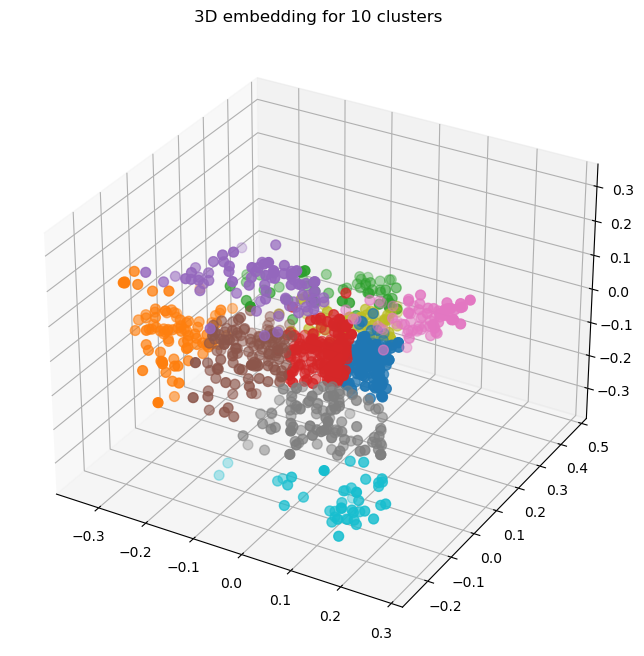

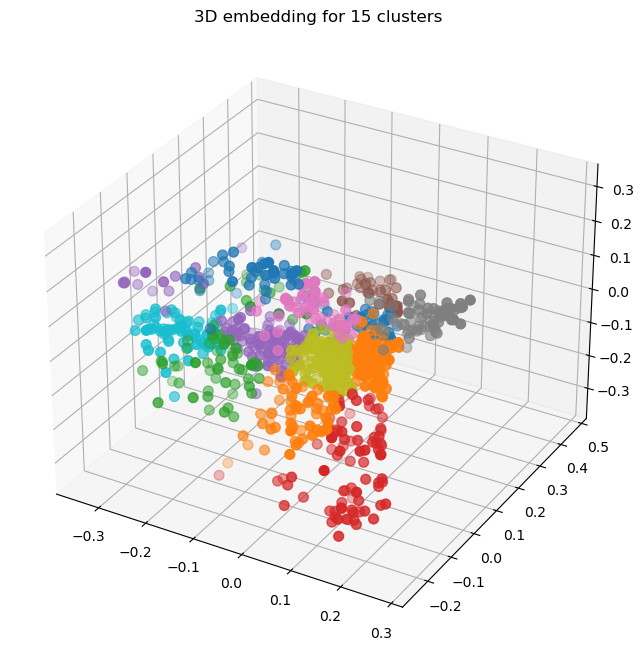

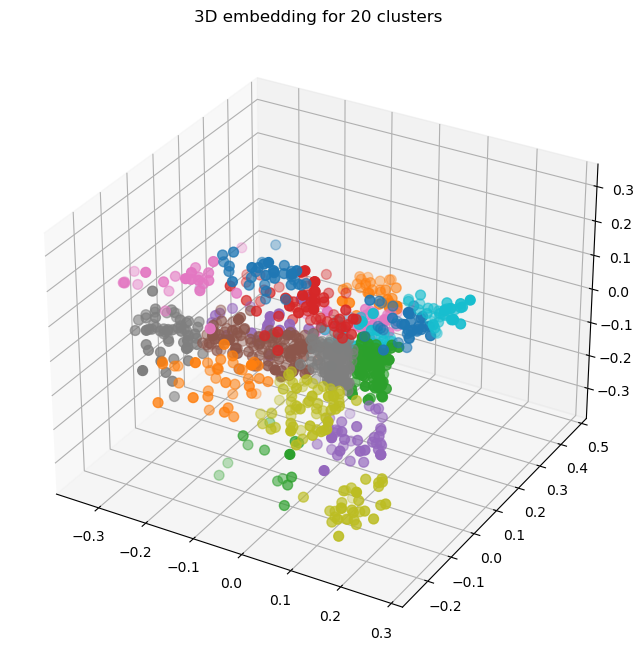

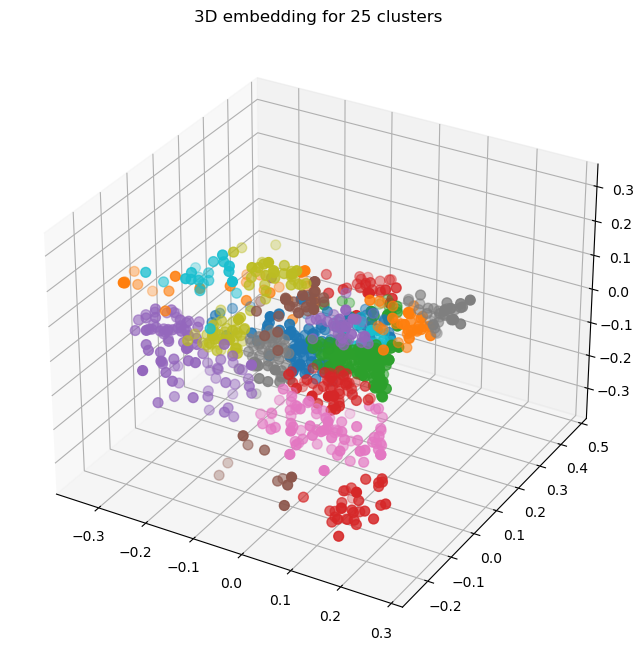

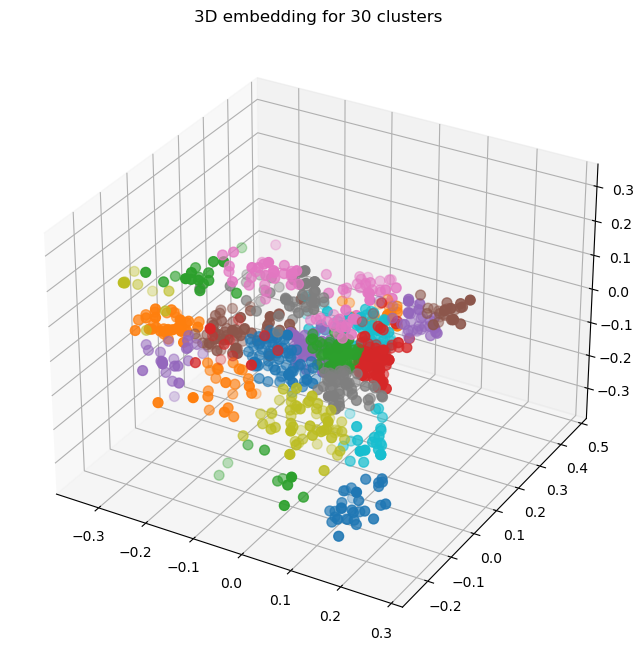

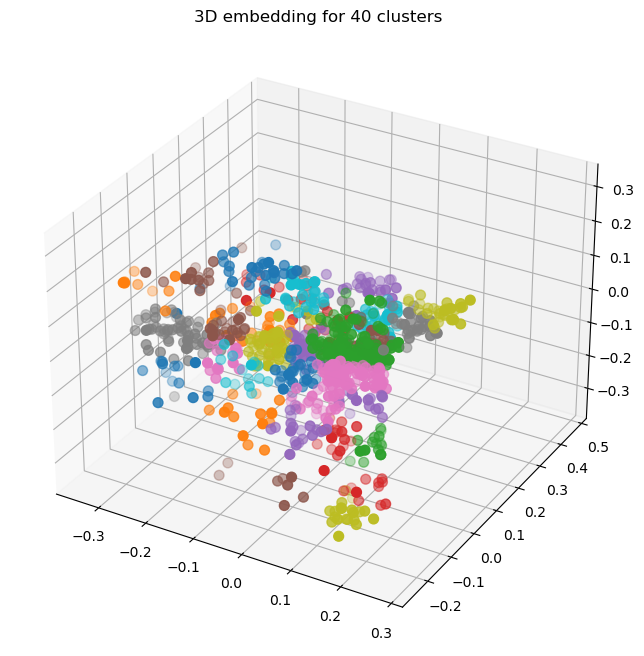

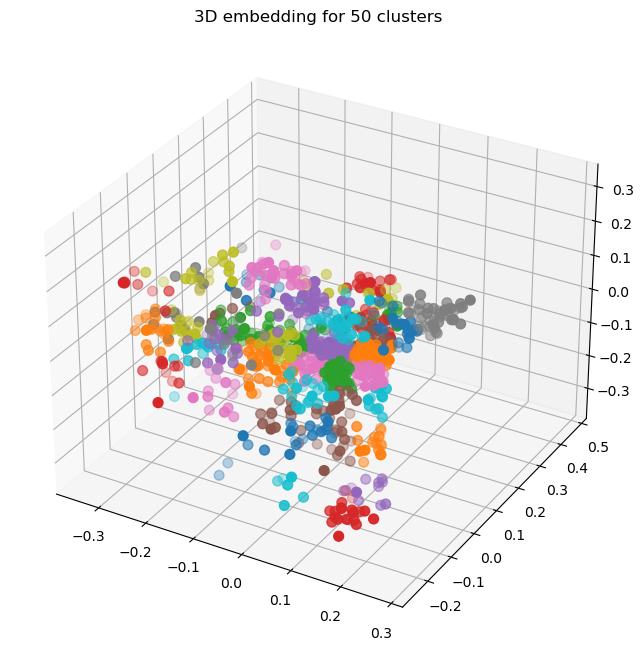

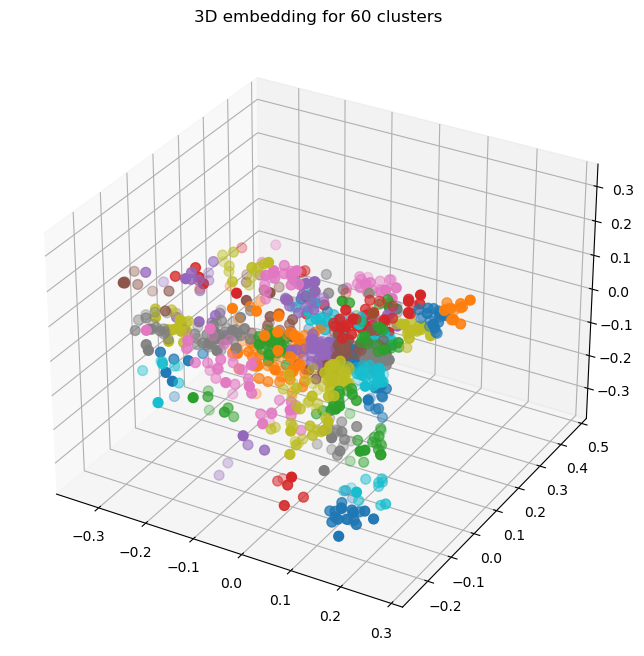

In [32]:
#3d embedding (p=3)

embedded_points_3d=CSE.get_embedded_vectors(p=3)

warnings.filterwarnings("ignore")

for k in [5,10,15,20,25,30, 40, 50, 60]:
    
    cluster_predictions=skl.cluster.KMeans(k).fit_predict(embedded_points_3d)
    
    fig = plt.figure(figsize=(8,8))
    ax = plt.axes(projection="3d")
    
    for i in range(k):
        indices=np.where(cluster_predictions==i)
        ax.scatter(embedded_points_3d[indices, 0], embedded_points_3d[indices, 1], embedded_points_3d[indices, 2], s=50)
    
    ax.set_title("3D embedding for " + str(k) + " clusters")

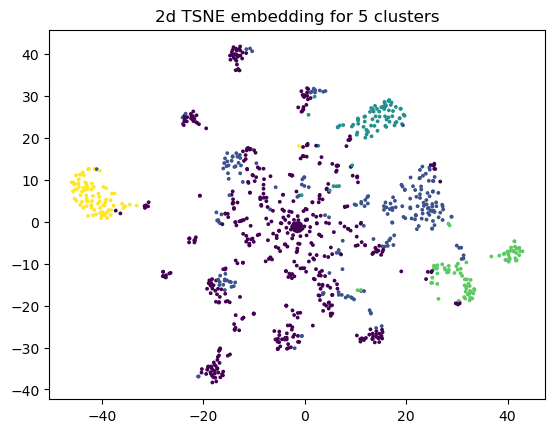

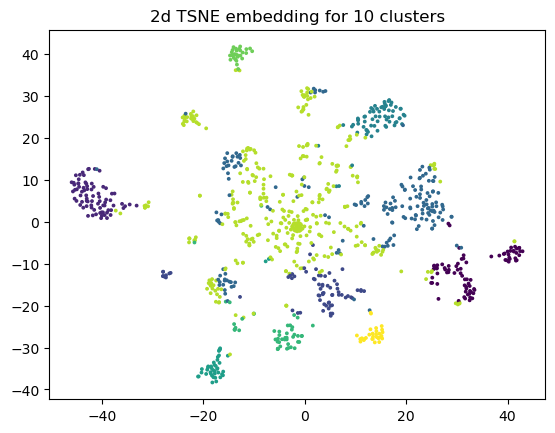

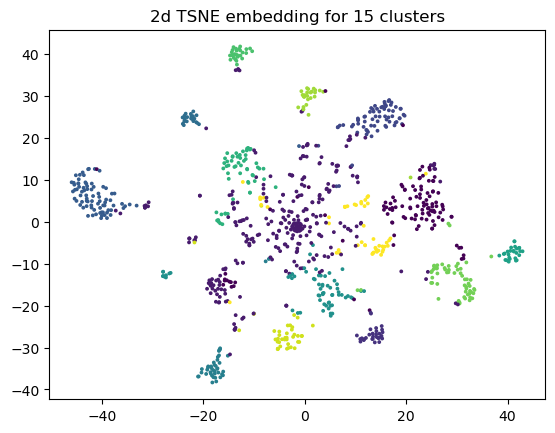

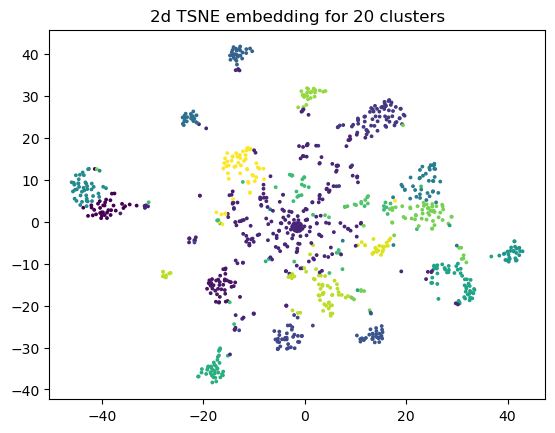

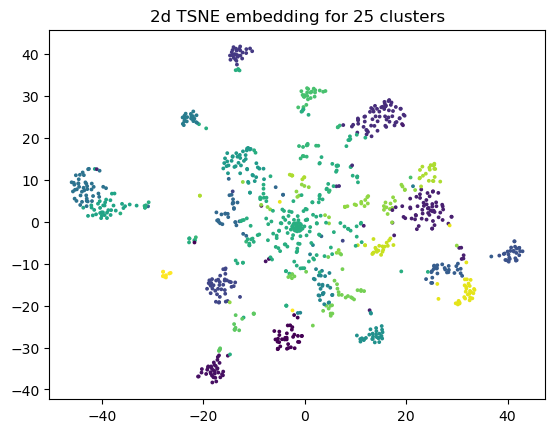

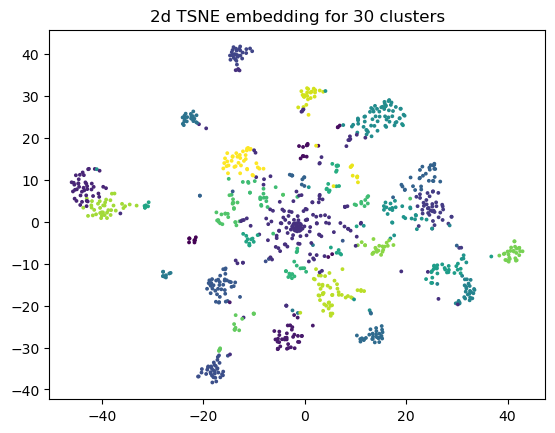

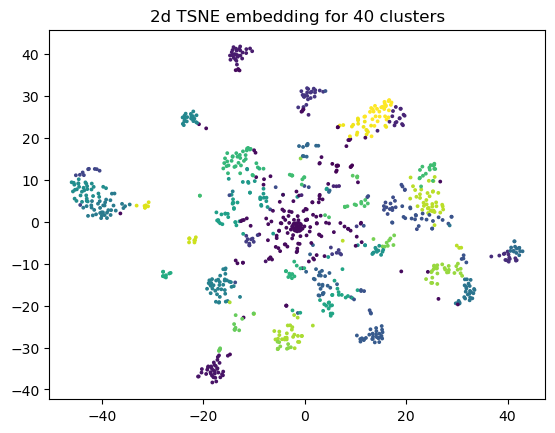

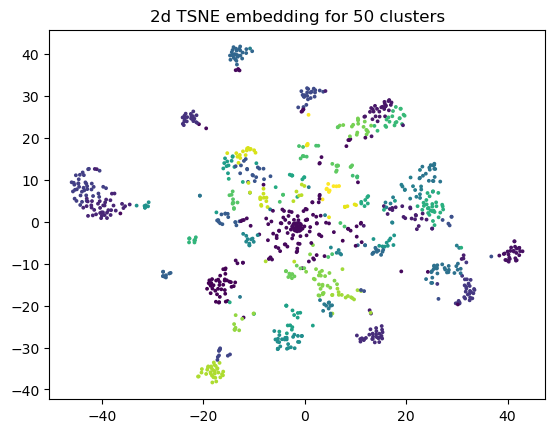

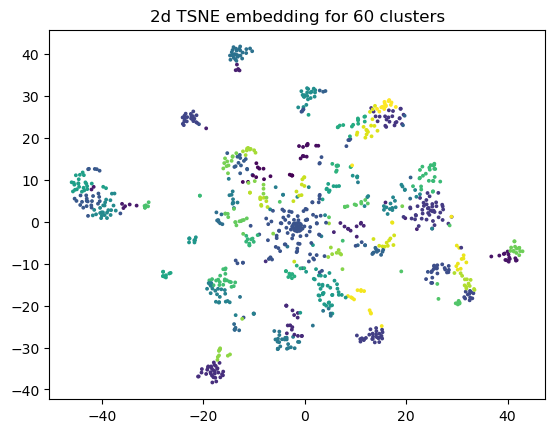

In [33]:
#embedding with p=p_opt

#here we do dimensionality reduction (with TSNE) only after finding the embedding with p=p_opt

from sklearn.manifold import TSNE

embedded_points_p_opt=CSE.get_embedded_vectors(p=p_opt)

for k in [5,10,15,20,25,30, 40, 50, 60]:
    
    cluster_predictions=skl.cluster.KMeans(k).fit_predict(embedded_points_p_opt)
    
    tsne = TSNE(n_components = 2, random_state=42)
    embedding= tsne.fit_transform(embedded_points_p_opt)
    plt.scatter(embedding[:,0], embedding[:,1], c=cluster_predictions, s=3, cmap='viridis')
    plt.title("2d TSNE embedding for " + str(k) + " clusters")
    plt.show()

In [ ]:
#section 6

In [34]:
# Initialize community members affiliation array
AFFILIATIONS = np.zeros((NUM_NODES, ))

# Fill out the affiliation array
with open("email-Eu-core-department-labels.txt") as file:
    for line in file:
        pair = [int(x) for x in line.split()]
        AFFILIATIONS[pair[0]] = pair[1]

# Number of organizations is 
print("The true number of clusters (departments) is: ", len(np.unique(AFFILIATIONS)))



The true number of clusters (departments) is:  42


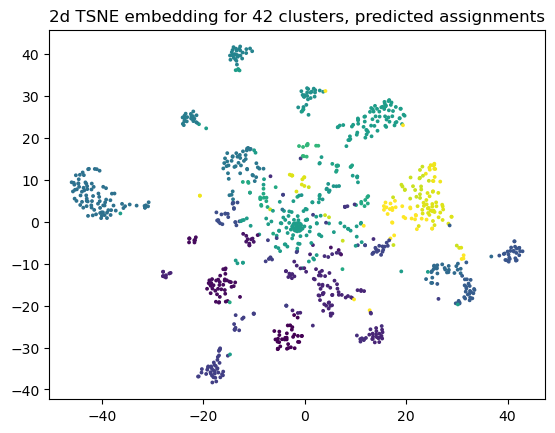

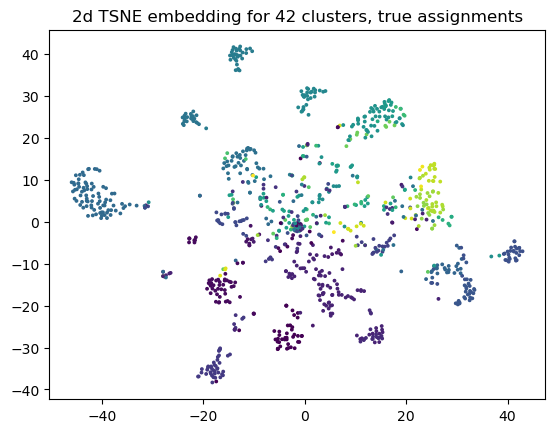

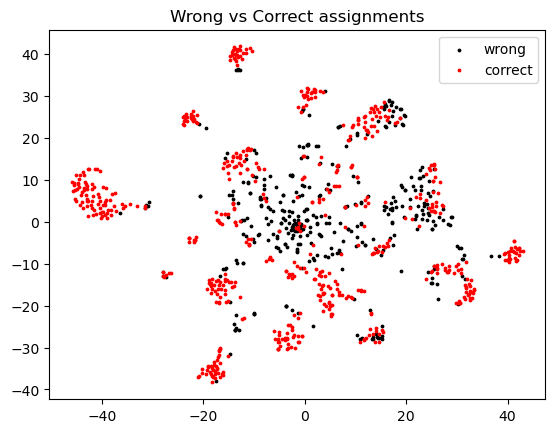

In [52]:
embedded_points_p_opt = CSE.get_embedded_vectors(p_opt)
predicted_assignments = skl.cluster.KMeans(42).fit_predict(embedded_points_p_opt)
matched_assignments= postprocess(predicted_assignments, AFFILIATIONS)

embedding= TSNE(n_components = 2, random_state=42).fit_transform(embedded_points_p_opt)
plt.scatter(embedding[:,0], embedding[:,1], c=matched_assignments, s=3, cmap='viridis')
plt.title("2d TSNE embedding for 42 clusters, predicted assignments")
plt.show()

plt.scatter(embedding[:,0], embedding[:,1], c=AFFILIATIONS, s=3, cmap='viridis')
plt.title("2d TSNE embedding for 42 clusters, true assignments")
plt.show()

correct_assignments=np.zeros(len(matched_assignments))
correct_assignments[np.where(matched_assignments==AFFILIATIONS)]=1

plt.scatter(embedding[np.where(correct_assignments==0),0], embedding[np.where(correct_assignments==0),1],s=3, c="black", label='wrong', cmap='viridis')
plt.scatter(embedding[np.where(correct_assignments==1),0], embedding[np.where(correct_assignments==1),1],s=3,c="red", label='correct', cmap='viridis')
plt.title("Wrong vs Correct assignments")
plt.legend()
#plt.legend(correct_assignments[correct_assignments==0])

plt.show()

In [53]:
accuracy = skl.metrics.accuracy_score(AFFILIATIONS, matched_assignments)
print('Accuracy: ', accuracy)
rand = skl.metrics.adjusted_rand_score(AFFILIATIONS, matched_assignments)
print('Adjusted Rand Index: ', rand)
inf = skl.metrics.normalized_mutual_info_score(AFFILIATIONS, matched_assignments)
print('Mutual Information Based Score: ', inf)

Accuracy:  0.6308457711442786
Adjusted Rand Index:  0.4123377621157655
Mutual Information Based Score:  0.6353168152924882
